In [2]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np
import pandas as pd
import random

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [95]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {device}")

data_dir = "dataset"

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToTensor()])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m - m * 0.2), int(m * 0.2)])
batch_size = 256    

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)


Selected device: cuda


In [113]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.main_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
        )
        self.mu = nn.LazyLinear(latent_dims)  # mean
        self.log_var = nn.LazyLinear(latent_dims)  # covar
    
    def sample(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def forward(self, x):
        x = x.to(device)
        x = self.main_block(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.sample(mu, log_var)
        return z, mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.main_block = nn.Sequential(
            nn.Linear(latent_dims, 3 * 3 * 32),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
			nn.BatchNorm2d(16),
			nn.ReLU(True),
			nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
			nn.BatchNorm2d(8),
			nn.ReLU(True),
			nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.to(device)
        return self.main_block(x)


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z, mu, log_var = self.encoder(x)
        return self.decoder(z), z, mu, log_var

In [117]:
### Set the random seed for reproducible results
torch.manual_seed(0)

latent_dims = 4
vae = VariationalAutoencoder(latent_dims=latent_dims)

lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(device)


/home/advait/miniconda3/envs/rohan/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


VariationalAutoencoder(
  (encoder): Encoder(
    (main_block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Flatten()
    )
    (mu): LazyLinear(in_features=0, out_features=4, bias=True)
    (log_var): LazyLinear(in_features=0, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (main_block): Sequential(
      (0): Linear(in_features=4, out_features=1024, bias=True)
      (1): UnFlatten()
      (2): ConvTranspose2d(4, 128, kernel_size=(5, 5), stride=(2, 2))
      (3): ReLU()
      (4): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
      (5): ReLU()
      (6): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2,

In [118]:
def loss_function(x_hat, x, mu, log_var):
    bce = F.binary_cross_entropy(x_hat, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kl

### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        x_hat, _, mu, log_var = vae(x)
        loss = loss_function(x_hat, x, mu, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)


### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():  # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            x_hat, _, mu, log_var = vae(x)
            loss = loss_function(x_hat, x, mu, log_var)
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)


def plot_ae_outputs(vae, n=10):
    plt.figure(figsize=(16, 4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets == i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        vae.eval()
        with torch.no_grad():
            x_hat, _, _, _ = vae(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Original images")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_hat.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Reconstructed images")
    plt.show()


In [119]:
num_epochs = 500
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    val_losses.append(val_loss)
    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )
    plot_ae_outputs(vae, n=10)
    if len(val_losses) >= 5 and val_losses[-5] < val_loss:
        print("Validation loss is no longer shrinking. Quitting early.")
        break



RuntimeError: Given transposed=1, weight of size [4, 128, 5, 5], expected input[256, 1024, 1, 1] to have 4 channels, but got 1024 channels instead

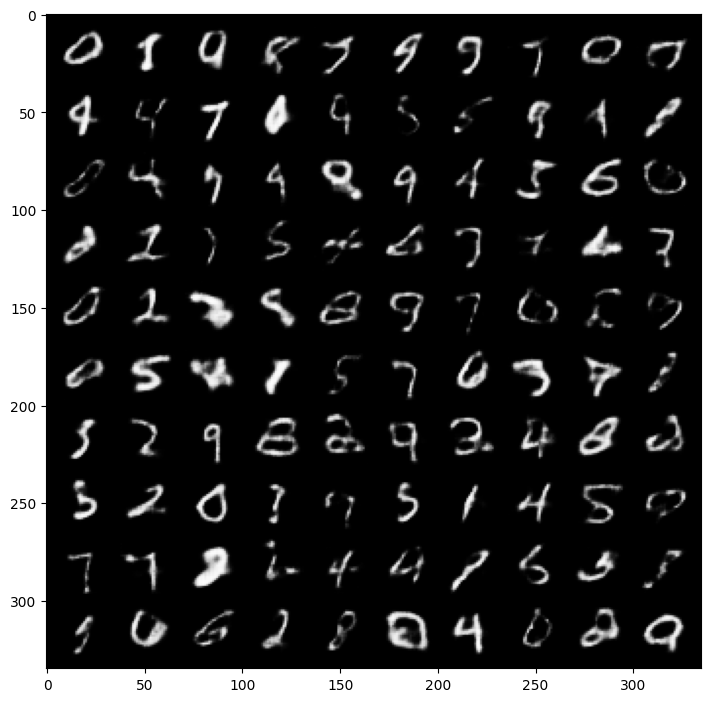

In [58]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    torch.manual_seed(3.14)
    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100], 10, 5))
    plt.show()


In [60]:
zero_indicies = [i for i, label in enumerate(train_dataset.targets) if label == 0]
zero_data = [train_dataset.data[i] for i in zero_indicies]

def display(images):
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))
    for i, image in enumerate(images):
        axs[i // 10, i % 10].imshow(image, cmap="gray")
    plt.show()
#display(zero_data[:100])

def inspect_image(image):
    image_tensor = torch.tensor(image, dtype=torch.float32, device=device)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.unsqueeze(0)

    vae.eval()
    z, mu, log_var = vae.encoder(image_tensor)
    print([x.cpu().squeeze() for x in (z, mu, log_var)])

for image in zero_data[:10]:
    inspect_image(image)


[tensor([-62.9219, -49.3829,  92.9215,  59.6663,  44.1764, -20.1404,   4.1988,
          9.0627, -29.1774,  49.4320], grad_fn=<SqueezeBackward0>), tensor([-62.9219, -49.3829,  92.9215,  59.6663,  44.1764, -20.1404,   4.1988,
          9.0615, -29.1774,  49.4320], grad_fn=<SqueezeBackward0>), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0014, 0.0000,
        0.0000], grad_fn=<SqueezeBackward0>)]
[tensor([-107.7868,  -59.2656,   88.8976,   46.8263,   33.6964,  -14.5874,
         -18.6515,    6.3637,  -36.1807,   36.2572],
       grad_fn=<SqueezeBackward0>), tensor([-107.7868,  -59.2656,   88.8976,   46.8263,   33.6964,  -14.5874,
         -18.6515,    6.3641,  -36.1807,   36.2572],
       grad_fn=<SqueezeBackward0>), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0000,
        0.0000], grad_fn=<SqueezeBackward0>)]
[tensor([-77.0251, -24.7829, 134.8225,  56.1307,  24.8262,   3.4885,  -4.5024,
          5.0503, -12.8910,  32.9298], grad_fn=<S

/tmp/ipykernel_25987/3332825893.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image, dtype=torch.float32, device=device)
